# Baseline Model

## Table of Contents

1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier # Import DummyClassifier for baseline
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

import warnings

## Model Choice

We chose a decision tree model because of its simplicity and interpretability. Since we are dealing with a classification problem, a tree-based approach allows for enhanced feature selection. Moreover, it is applicable to both categorical and numerical data, which we have, without the need for
preprocessing, and it can also recognize nonlinear relationships.


- This script will show the performance by simply predicting based on the class distribution of your target variable, which is a crucial benchmark


## Feature Selection

We are exploiting our model using all available variables, afterwards we will apply a SHAP method in order to indentify the more and less important features for the target variable.


In [34]:
df = pd.read_csv('../1_DatasetCharacteristics/share_w6_retirees_cleaned.csv')
df.head()

,country,language,ac011__1,ac012__1,ac014__1,ac015__1,ac016__1,ac017__1,ac018__1,ac019__1,...,ep064d1_7_w9,ep064d2_7_w9,ep064d3_7_w9,ep064d4_7_w9,ep064d5_7_w9,ep064d6_7_w9,ep064d7_7_w9,ep064d8_7_w9,ep064d9_7_w9,ep064d10_7_w9
0,11,11,1.0,8.0,3.0,3.0,4.0,1.0,2.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11,11,1.0,9.0,2.0,3.0,4.0,2.0,2.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11,11,1.0,9.0,4.0,4.0,4.0,1.0,3.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11,11,1.0,10.0,4.0,4.0,4.0,1.0,3.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11,11,1.0,10.0,4.0,3.0,4.0,1.0,4.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
y = df['ep036__7']
X = df.drop('ep036__7',axis=1)

## Running Feature Selection Experiment


In [36]:


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

pipeline = Pipeline([
    ('clf', DecisionTreeClassifier(random_state=42))
])

param_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [None, 5, 10, 15, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['auto', 'sqrt', 'log2']
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # cross-validation


grid_search = GridSearchCV(  # GridSearchCV for tuning
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_.named_steps['clf']

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


/home/metaphysicist/Coding/2025/opencampus/Aging/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
450 fits failed out of a total of 1350.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "/home/metaphysicist/Coding/2025/opencampus/Aging/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/metaphysicist/Coding/2025/opencampus/Aging/.venv/lib/python3.10/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/metaphysicist/Coding/2025/op

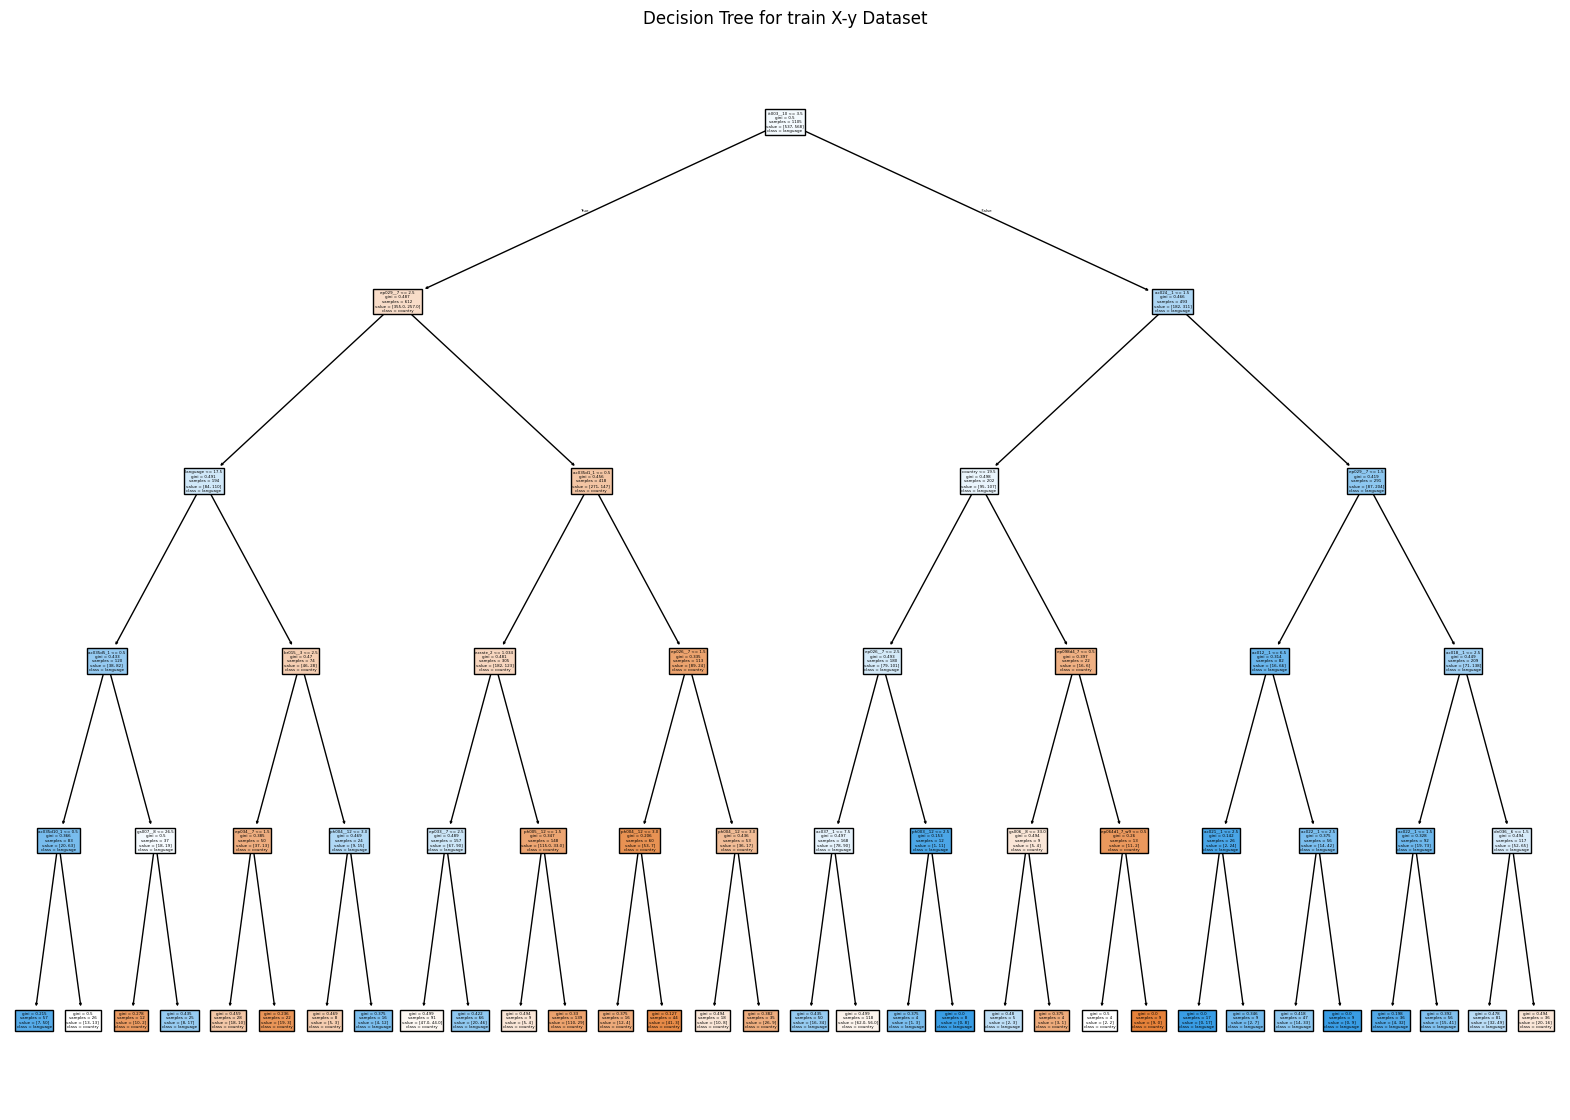

<Figure size 640x480 with 0 Axes>

In [37]:
plt.figure(figsize=(20, 14))
plot_tree(best_model, feature_names=X_train.columns, class_names=X_train.columns, filled=True)
plt.title("Decision Tree for train X-y Dataset")
plt.show()
plt.savefig('docs/decision_tree.png')

In [38]:
tree_rules = export_text(best_model, feature_names=list(X_train.columns))

# Save to a text file
with open("docs/decision_tree_rules.txt", "w") as f:
    f.write(tree_rules)

In [39]:
importances = pd.Series(best_model.feature_importances_, index=X.columns)
sorted_importances = importances[importances>0.01].sort_values(ascending=False)

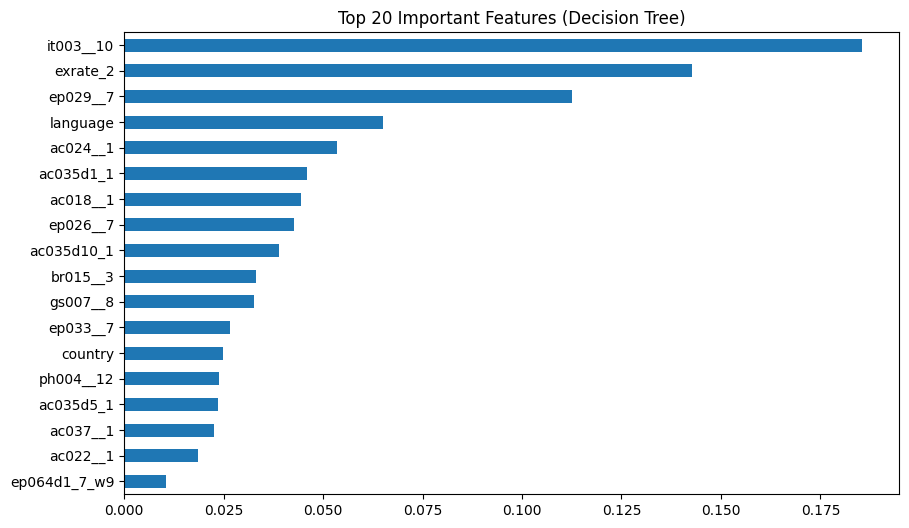

In [40]:
top_n = 20  # I have decided to use top 18 features for our analysis based on elbow/visual inspection
plt.figure(figsize=(10, 6))
sorted_importances[:top_n].plot(kind='barh')
plt.title(f"Top {top_n} Important Features (Decision Tree)")
plt.gca().invert_yaxis()
plt.show()

In [41]:
def get_top_features(model, X, top_n=20):
    importances = pd.Series(model.feature_importances_, index=X.columns)
    sorted_importances = importances[importances>0.02].sort_values(ascending=False)

    return sorted_importances[:top_n].index.tolist()


print(get_top_features(best_model, X_train)) # print("Top 20 Important Features:")
print(len(get_top_features(best_model, X_train)))


['it003__10', 'exrate_2', 'ep029__7', 'language', 'ac024__1', 'ac035d1_1', 'ac018__1', 'ep026__7', 'ac035d10_1', 'br015__3', 'gs007__8', 'ep033__7', 'country', 'ph004__12', 'ac035d5_1', 'ac037__1']
16


In [42]:
selected_features = get_top_features(best_model, X_train)
X_reduced = X_train[selected_features]

In [43]:
X_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1105 entries, 1076 to 168
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   it003__10   1105 non-null   float64
 1   exrate_2    1105 non-null   float64
 2   ep029__7    1105 non-null   float64
 3   language    1105 non-null   int64  
 4   ac024__1    1105 non-null   float64
 5   ac035d1_1   1105 non-null   float64
 6   ac018__1    1105 non-null   float64
 7   ep026__7    1105 non-null   float64
 8   ac035d10_1  1105 non-null   float64
 9   br015__3    1105 non-null   float64
 10  gs007__8    1105 non-null   float64
 11  ep033__7    1105 non-null   float64
 12  country     1105 non-null   int64  
 13  ph004__12   1105 non-null   float64
 14  ac035d5_1   1105 non-null   float64
 15  ac037__1    1105 non-null   float64
dtypes: float64(14), int64(2)
memory usage: 146.8 KB


## Implementation


In [44]:
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()

numerical_transformer = Pipeline(steps=[ # only numerical because we dont have categorical features
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
    ],
    remainder='passthrough' # Keep other columns (if any) as they are
)

baseline_model_config = {
    'model_name': 'Baseline (Stratified Dummy)',
    'model': DummyClassifier(strategy='stratified', random_state=42),
    'params': {} # No meaningful params to tune for DummyClassifier
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Cross-Validation Strategy 

 
print(f"\n--- Starting Experiment for: {baseline_model_config['model_name']} ---") # Experiment for Baseline Model

# Create the full pipeline: Preprocessing -> Classifier
# For DummyClassifier, preprocessing is not strictly necessary for its logic
# but we keep it in the pipeline for consistency in the framework.
# The DummyClassifier itself ignores X.
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', baseline_model_config['model'])
])

# GridSearchCV (even with empty params) for cross-validation evaluation
grid_search = GridSearchCV(
    pipeline,
    param_grid=baseline_model_config['params'], # This will be empty, so no real search
    cv=cv_strategy,
    scoring='roc_auc', # ROC AUC is a good metric for imbalanced binary classification
    n_jobs=-1,         # Use all available CPU cores
    verbose=1          # More verbose output during search
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Store results (though simple for baseline)
baseline_results = {
    'best_estimator': grid_search.best_estimator_,
    'best_params': grid_search.best_params_,
    'best_score': grid_search.best_score_, # Mean cross-validated score of the best_estimator
    'cv_results': grid_search.cv_results_
}



--- Starting Experiment for: Baseline (Stratified Dummy) ---
Fitting 5 folds for each of 1 candidates, totalling 5 fits


## Evaluation


In [45]:

print(f"\nFinished {baseline_model_config['model_name']}:")
print(f"  Best ROC AUC (CV): {baseline_results['best_score']:.4f}")
print(f"  Best Parameters: {baseline_results['best_params']}")

# Evaluate the best model (which is just the baseline) on the unseen test set
y_pred = grid_search.best_estimator_.predict(X_test)
y_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1] # Probability of the positive class (1)

# --- Debugging Check (if you encounter ValueError again) ---
print(f"\n--- Debugging roc_auc_score inputs ---")
print(f"y_test unique values: {np.unique(y_test)}")
print(f"y_proba shape: {y_proba.shape}")
print(f"y_proba sample (first 5): {y_proba[:5]}")
print(f"Are there NaNs in y_proba? {np.isnan(y_proba).any()}")
print(f"Are there infinities in y_proba? {np.isinf(y_proba).any()}")
# --- End Debugging Check ---

test_roc_auc = roc_auc_score(y_test, y_proba)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
test_pr_auc = auc(recall, precision)

print(f"\n--- Test Set Evaluation for {baseline_model_config['model_name']} ---")
print(f"  Test ROC AUC: {test_roc_auc:.4f}")
print(f"  Test PR AUC: {test_pr_auc:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, target_names=['Not Retire', 'Retire']))
print("-" * 50)

print(f"\nBaseline Model Performance (Test ROC AUC): {test_roc_auc:.4f}")



Finished Baseline (Stratified Dummy):
  Best ROC AUC (CV): 0.4989
  Best Parameters: {}

--- Debugging roc_auc_score inputs ---
y_test unique values: [0. 1.]
y_proba shape: (277,)
y_proba sample (first 5): [1. 0. 0. 0. 1.]
Are there NaNs in y_proba? False
Are there infinities in y_proba? False

--- Test Set Evaluation for Baseline (Stratified Dummy) ---
  Test ROC AUC: 0.4909
  Test PR AUC: 0.6282

Classification Report (Test Set):
              precision    recall  f1-score   support

  Not Retire       0.48      0.49      0.48       135
      Retire       0.50      0.49      0.50       142

    accuracy                           0.49       277
   macro avg       0.49      0.49      0.49       277
weighted avg       0.49      0.49      0.49       277

--------------------------------------------------

Baseline Model Performance (Test ROC AUC): 0.4909


Finished Baseline (Stratified Dummy):
Best ROC AUC (CV): 0.4989
Best Parameters: {}

--- Debugging roc_auc_score inputs ---
y_test unique values: [0. 1.]
y_proba shape: (277,)
y_proba sample (first 5): [1. 0. 0. 0. 1.]
Are there NaNs in y_proba? False
Are there infinities in y_proba? False

--- Test Set Evaluation for Baseline (Stratified Dummy) ---
Test ROC AUC: 0.4909
Test PR AUC: 0.6282

Classification Report (Test Set):
precision recall f1-score support

Not Retire 0.48 0.49 0.48 135
Retire 0.50 0.49 0.50 142

    accuracy                           0.49       277

macro avg 0.49 0.49 0.49 277
weighted avg 0.49 0.49 0.49 277

---

Baseline Model Performance (Test ROC AUC): 0.4909
